In [22]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [23]:
IMAGE_SIZE = 256
BATCH_SIZE = 256
CHANNELS =3
EPOCHS = 10
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 15

In [24]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 20638 files belonging to 15 classes.


In [25]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

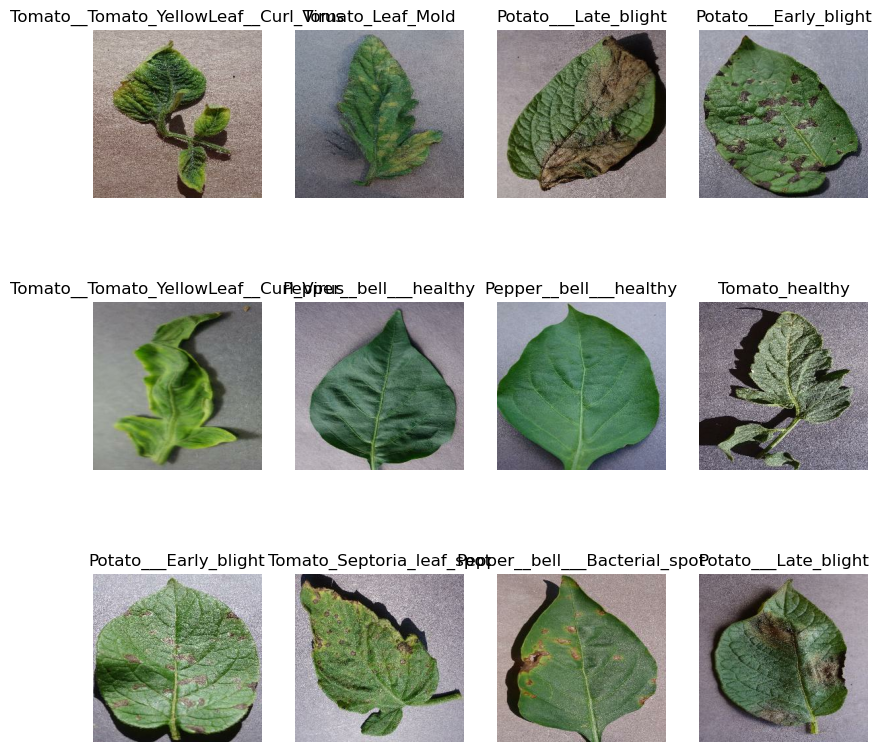

In [26]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,1+i)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [27]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000):
  assert  (train_split + test_split + val_split) == 1

  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  val_size = int(val_split * ds_size)
    
  train_ds = ds.take(train_size)    
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)
    
  return train_ds, val_ds, test_ds

In [28]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

56
12
13


In [29]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)

In [30]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [31]:
data_augmentation = tf.keras.Sequential([
 layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
 layers.experimental.preprocessing.RandomRotation(0.2),
])

In [32]:
nput_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 15

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (256, 256, 256, 3)        0         
                                                                 
 conv2d_3 (Conv2D)           (256, 254, 254, 32)       896       
                                                                 
 max_pooling2d_3 (MaxPooling  (256, 127, 127, 32)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (256, 125, 125, 64)       18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (256, 62, 62, 64)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (256, 60, 60, 64)        

In [33]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/10
56/56 [==============================] - 400s 7s/step - loss: 2.0621 - accuracy: 0.3481 - val_loss: 1.4224 - val_accuracy: 0.5723
Epoch 2/10
56/56 [==============================] - 369s 7s/step - loss: 1.0416 - accuracy: 0.6782 - val_loss: 0.7558 - val_accuracy: 0.7559
Epoch 3/10
56/56 [==============================] - 372s 7s/step - loss: 0.7103 - accuracy: 0.7723 - val_loss: 0.5566 - val_accuracy: 0.8174
Epoch 4/10
56/56 [==============================] - 439s 8s/step - loss: 0.5175 - accuracy: 0.8302 - val_loss: 0.4712 - val_accuracy: 0.8420
Epoch 5/10
56/56 [==============================] - 451s 8s/step - loss: 0.4080 - accuracy: 0.8668 - val_loss: 0.3847 - val_accuracy: 0.8753
Epoch 6/10
56/56 [==============================] - 444s 8s/step - loss: 0.3420 - accuracy: 0.8860 - val_loss: 0.3443 - val_accuracy: 0.8847
Epoch 7/10
56/56 [==============================] - 514s 9s/step - loss: 0.2572 - accuracy: 0.9166 - val_loss: 0.2187 - val_accuracy: 0.9351
Epoch 8/10
56

In [34]:
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

13/13 [==============================] - 42s 1s/step - loss: 0.1888 - accuracy: 0.9429
Test Loss: 0.1887810081243515
Test Accuracy: 0.9429086446762085


In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

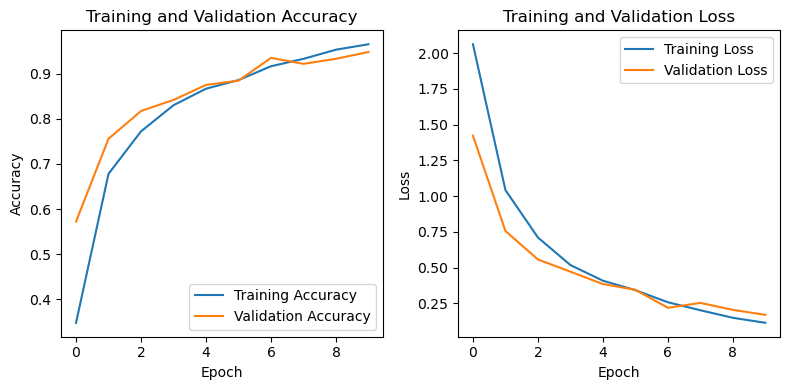

In [36]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


In [37]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 23ms/step


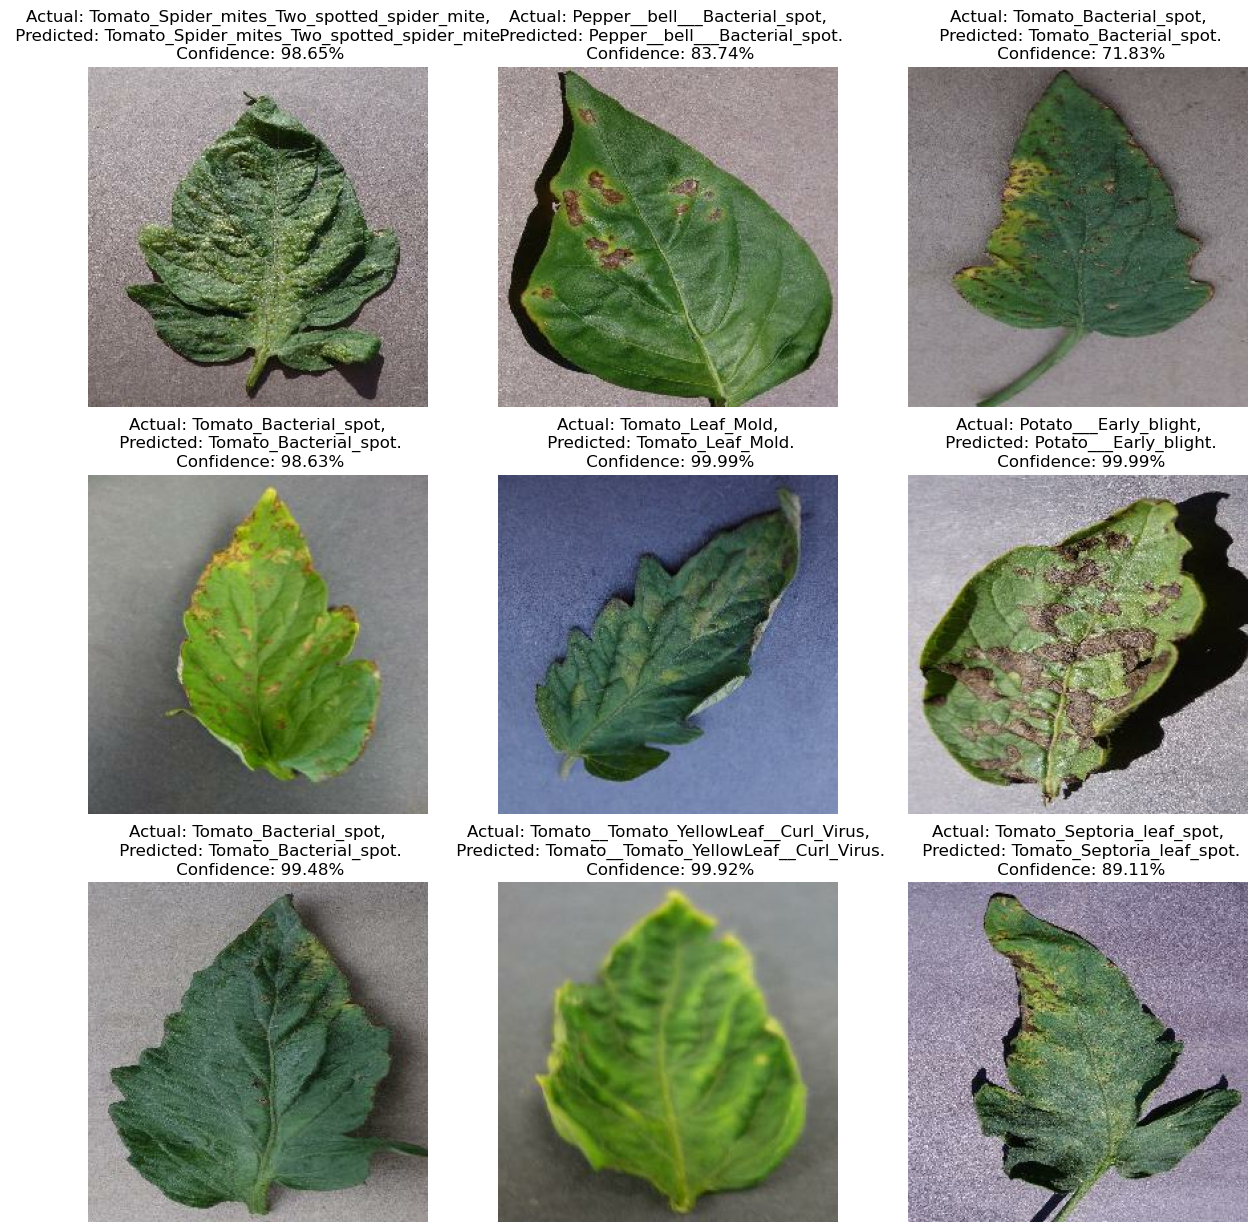

In [38]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [40]:
# Make predictions on the test set
y_true = []
y_pred = []
for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels)
    y_pred.extend(np.argmax(predictions, axis=1))

8/8 [==============================] - 1s 155ms/step


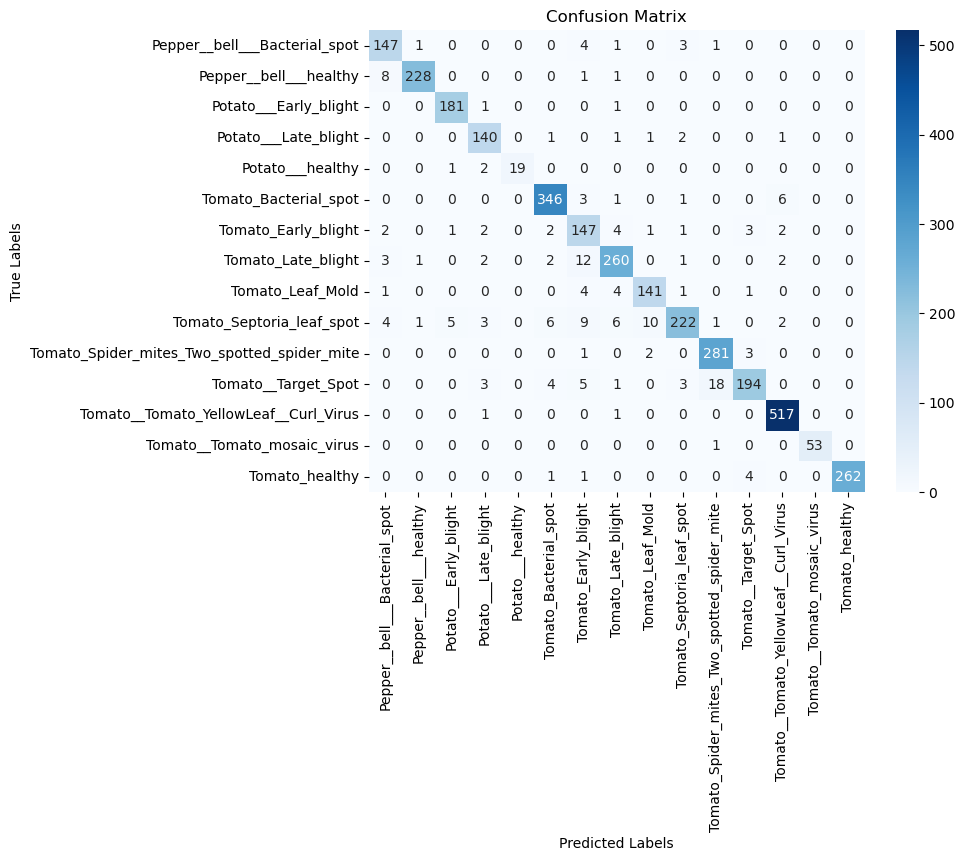

In [41]:
# Get the class names from the dataset
class_names = dataset.class_names

# Calculate the confusion matrix
confusion = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [42]:
from sklearn.metrics import confusion_matrix, classification_report
classification_rep = classification_report(y_true, y_pred, target_names=class_names)

# Print the classification report
print("Classification Report:\n", classification_rep)

Classification Report:
                                              precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.89      0.94      0.91       157
                     Pepper__bell___healthy       0.99      0.96      0.97       238
                      Potato___Early_blight       0.96      0.99      0.98       183
                       Potato___Late_blight       0.91      0.96      0.93       146
                           Potato___healthy       1.00      0.86      0.93        22
                      Tomato_Bacterial_spot       0.96      0.97      0.96       357
                        Tomato_Early_blight       0.79      0.89      0.84       165
                         Tomato_Late_blight       0.93      0.92      0.92       283
                           Tomato_Leaf_Mold       0.91      0.93      0.92       152
                  Tomato_Septoria_leaf_spot       0.95      0.83      0.88       269
Tomato_Spider_mites_Two_spotted_spider_m